# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step2 : 데이터 전처리

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

폰트 지정

In [78]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기

In [79]:
RANDOM_STATE = 110

data = pd.read_csv("../../project/data/clean_financial_data.csv", encoding='utf-8-sig', low_memory=False)
print(data.shape)

(38639, 543)


In [80]:
data.columns

Index(['업체코드', '종목코드', '종목명', '2020/총자산증가율', '2021/총자산증가율', '2022/총자산증가율',
       '2023/총자산증가율', '2024/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율',
       ...
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2023/조세공과(구성비)',
       '2024/조세공과(구성비)', '2020/감가상각비(구성비)', '2021/감가상각비(구성비)',
       '2022/감가상각비(구성비)', '2023/감가상각비(구성비)', '2024/감가상각비(구성비)'],
      dtype='object', length=543)

### 1. 결측값 처리

In [81]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 각 열에 대해 결측치 개수와 비율 계산
missing_data = data[columns_with_ratio].isnull().sum()
missing_ratio = (missing_data / len(data)) * 100  # 결측치 비율 계산 (퍼센트)

# 결측치가 있는 열만 출력
missing_summary = pd.DataFrame({
    '결측치 개수': missing_data,
    '결측치 비율 (%)': missing_ratio
}).loc[missing_data > 0]

# 결과 출력
print(missing_summary)

                 결측치 개수  결측치 비율 (%)
2020/영업이익이자보상비율    8768   22.692099
2021/영업이익이자보상비율    6378   16.506638
2022/영업이익이자보상비율    4472   11.573798
2023/영업이익이자보상비율    4810   12.448562
2024/영업이익이자보상비율   37943   98.198711


2024년 데이터의 경우 '영업이익이자보상비율' 변수를 포함해서 대부분의 값이 결측으로 존재  
-> 24년도 데이터 제거

In [82]:
# '2024'가 열 이름에 포함된 열들을 제거
data = data.drop(columns=[col for col in data.columns if '2024' in col], errors='ignore')
print(data.shape)

(38639, 435)


3년 연속 '영업이익이자보상비율' < 1 인 경우 부실기업으로 판정  
-> 한개의 연도라도 '영업이익이자보상비율'의 값이 결측인 경우 해당 행 제거

In [83]:
# '영업이익이자보상비율'이 포함된 열들 찾기
columns_with_ratio = [col for col in data.columns if '영업이익이자보상비율' in col]

# 결측치가 있는 행 제거
data = data.dropna(subset=columns_with_ratio)

# 결과 확인
print(data.shape)

(27604, 435)


'영업이익이자보상비율'을 제외하고 결측값이 존재하는 경우 중앙값(median) 대체  
-> 이때 수치형변수들에 대해서만 적용(재무비율이 아닌 업체코드, 종목코드, 종목명에는 적용 x)

In [84]:
data.dtypes

업체코드                object
종목코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
                    ...   
2023/조세공과(구성비)     float64
2020/감가상각비(구성비)    float64
2021/감가상각비(구성비)    float64
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
Length: 435, dtype: object

In [85]:
# 숫자형 변수 개수 확인
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_count = len(numeric_columns)

print(f"숫자형 변수 개수: {numeric_count}개")

숫자형 변수 개수: 432개


업체코드, 종목코드, 종목명 변수를 제외한 432개 변수들에 대해서 중앙값 대체

In [86]:
# 각 열의 결측값을 중앙값으로 대체
data = data.fillna(data.median(numeric_only=True))

### 2. 이상치 처리

이상치 처리 방법으로 원저라이징 방법 사용  

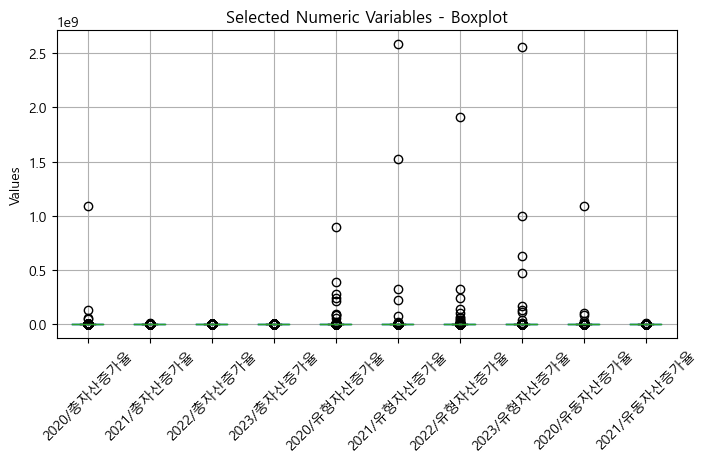

In [87]:
# 숫자형 변수 선택
numeric_columns = data.select_dtypes(include=['number']).columns

# 숫자형 변수 중 일부 선택 (예: 앞에서 10개)
selected_columns = numeric_columns[:10]

# 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(8, 4))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot")
plt.ylabel("Values")
plt.show()

상하위 1% 윈저라이징 방법을 적용

-> 상위 0~1% 값의 데이터는 상위 1% 값으로, 하위 99~100% 값의 데이터는 하위 99% 값으로 변환

In [88]:
from scipy.stats.mstats import winsorize

# 숫자형 데이터에만 윈저라이징 적용
numeric_columns = data.select_dtypes(include=['number']).columns

for col in numeric_columns:
    # 0.01 이하와 0.99 이상을 해당 값으로 제한
    lower_limit = data[col].quantile(0.01)
    upper_limit = data[col].quantile(0.99)
    data[col] = data[col].clip(lower=lower_limit, upper=upper_limit)

data.head(3)

,업체코드,종목코드,종목명,2020/총자산증가율,2021/총자산증가율,2022/총자산증가율,2023/총자산증가율,2020/유형자산증가율,2021/유형자산증가율,2022/유형자산증가율,...,2022/임차료(구성비),2023/임차료(구성비),2020/조세공과(구성비),2021/조세공과(구성비),2022/조세공과(구성비),2023/조세공과(구성비),2020/감가상각비(구성비),2021/감가상각비(구성비),2022/감가상각비(구성비),2023/감가상각비(구성비)
0,N350605,A000020,동화약품,7.57,2.70,3.27,10.23,19.67,10.41,7.64,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
1,N320498,A000040,KR모터스,-36.76,1.45,-0.52,-4.89,-0.29,5.78,4.85,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22
2,N320684,A000050,경방,-6.47,0.15,-6.09,-1.40,-36.42,-23.56,665.18,...,1.32,1.41,2.14,2.11,2.12,2.13,7.96,7.83,8.03,8.22


상하위 1% 윈저라이징 적용 후 박스플롯 시각화

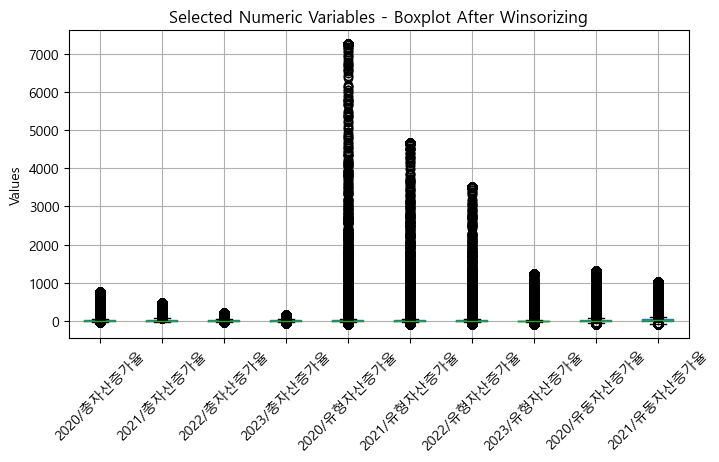

In [89]:
# 이전에 선택한 numeric_columns 그대로 사용
selected_columns = numeric_columns[:10]  

# 윈저라이징 후 선택된 변수에 대한 박스플롯 그리기
plt.figure(figsize=(8, 4))
data[selected_columns].boxplot(rot=45)
plt.title("Selected Numeric Variables - Boxplot After Winsorizing")
plt.ylabel("Values")
plt.show()

### 3. 파생변수 생성

#### 3.1 2023/부실기업

3년 연속 '영업이익이자보상비율' < 1 인 경우 부실기업으로 판정 

In [41]:
# 2023/부실기업 변수 생성 및 값 할당
data['2023/부실기업'] = ((data['2021/영업이익이자보상비율'] < 1) & 
                        (data['2022/영업이익이자보상비율'] < 1) & 
                        (data['2023/영업이익이자보상비율'] < 1)).astype(int)

print("\n2023/부실기업 변수 값:")
print(data['2023/부실기업'].value_counts())


2023/부실기업 변수 값:
0    22473
1     5131
Name: 2023/부실기업, dtype: int64


In [42]:
data.isnull().sum()

업체코드                   0
종목코드               24402
종목명                    1
2020/총자산증가율            0
2021/총자산증가율            0
                   ...  
2020/감가상각비(구성비)        0
2021/감가상각비(구성비)        0
2022/감가상각비(구성비)        0
2023/감가상각비(구성비)        0
2023/부실기업              0
Length: 436, dtype: int64

종목명이 없는 행 1개 존재 -> 해당 행 제거

In [43]:
# '종목명' 열에서 null 값이 있는 행 제거
data = data[data['종목명'].notnull()]

#### 3.2 상장여부

이때 종목코드 x -> 해당 기업이 상장되지 않은 경우

In [44]:
# '종목코드' 열의 값이 있으면 1, 없으면 0을 부여하는 새로운 열 생성
data['상장여부'] = data['종목코드'].notnull().astype(int)

# '종목코드' 열 제거
data = data.drop(columns=['종목코드'])

In [45]:
data.dtypes

업체코드                object
종목명                 object
2020/총자산증가율        float64
2021/총자산증가율        float64
2022/총자산증가율        float64
                    ...   
2021/감가상각비(구성비)    float64
2022/감가상각비(구성비)    float64
2023/감가상각비(구성비)    float64
2023/부실기업            int32
상장여부                 int32
Length: 436, dtype: object

### 4. 변수 선정

데이터셋의 2가지 경우에 따라 예측 성능을 비교하고자 구별
- 21~22년도 데이터  
- 20~22년도 데이터  

In [46]:
# 연도 필터링을 위한 연도 목록
years_21to22 = ['2021', '2022'] # 21~22년도 데이터만 필터링
years_20to22 = ['2020', '2021', '2022'] # 20~22년도 데이터만 필터링

cols_to_keep_21to22 = ['업체코드', '종목명', '상장여부', '2023/부실기업'] + [col for col in data.columns if any(year in col for year in years_21to22)]
cols_to_keep_20to22 = ['업체코드', '종목명', '상장여부', '2023/부실기업'] + [col for col in data.columns if any(year in col for year in years_20to22)]

# 필터링된 열들로 새로운 데이터프레임 생성
data_21to22 = data[cols_to_keep_21to22]
data_20to22 = data[cols_to_keep_20to22]

# 결과 확인
print("필터링된 데이터프레임의 열들:")
print(data_21to22.columns)
print(data_20to22.columns)

필터링된 데이터프레임의 열들:
Index(['업체코드', '종목명', '상장여부', '2023/부실기업', '2021/총자산증가율', '2022/총자산증가율',
       '2021/유형자산증가율', '2022/유형자산증가율', '2021/유동자산증가율', '2022/유동자산증가율',
       ...
       '2021/인건비(구성비)', '2022/인건비(구성비)', '2021/금융비용(구성비)', '2022/금융비용(구성비)',
       '2021/임차료(구성비)', '2022/임차료(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)',
       '2021/감가상각비(구성비)', '2022/감가상각비(구성비)'],
      dtype='object', length=220)
Index(['업체코드', '종목명', '상장여부', '2023/부실기업', '2020/총자산증가율', '2021/총자산증가율',
       '2022/총자산증가율', '2020/유형자산증가율', '2021/유형자산증가율', '2022/유형자산증가율',
       ...
       '2022/금융비용(구성비)', '2020/임차료(구성비)', '2021/임차료(구성비)', '2022/임차료(구성비)',
       '2020/조세공과(구성비)', '2021/조세공과(구성비)', '2022/조세공과(구성비)', '2020/감가상각비(구성비)',
       '2021/감가상각비(구성비)', '2022/감가상각비(구성비)'],
      dtype='object', length=328)


In [47]:
data_20to22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27603 entries, 0 to 38638
Columns: 328 entries, 업체코드 to 2022/감가상각비(구성비)
dtypes: float64(324), int32(2), object(2)
memory usage: 69.1+ MB


In [48]:
data_21to22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27603 entries, 0 to 38638
Columns: 220 entries, 업체코드 to 2022/감가상각비(구성비)
dtypes: float64(216), int32(2), object(2)
memory usage: 46.3+ MB


#### 4.1 t-test

귀무가설 (H0): 부실기업 그룹과 부실기업이 아닌 그룹 간에 특정 변수의 평균에 차이가 없다  
-> 해당 가설을 검정

In [49]:
from scipy.stats import ttest_ind
import pandas as pd

def perform_ttest(data, target_column):
    # 타겟 변수 설정
    group_0 = data[data[target_column] == 0]  # 부실기업이 아닌 그룹
    group_1 = data[data[target_column] == 1]  # 부실기업 그룹

    # 숫자형 변수 선택 및 제외할 열들 제거
    numeric_columns = data.select_dtypes(include=['number']).columns.drop(target_column)

    # t-검정 결과 저장
    t_test_results = []

    for col in numeric_columns:
        # 각 변수에 대해 t-검정 수행
        t_stat, p_value = ttest_ind(group_0[col].dropna(), group_1[col].dropna(), equal_var=False)  # Welch's t-test
        t_test_results.append({'변수': col, 't-값': t_stat, 'p-값': p_value})

    # t-검정 결과를 데이터프레임으로 정리
    t_test_df = pd.DataFrame(t_test_results)

    # 유의미한 변수 필터링 (p-값 < 0.05)
    significant_vars = t_test_df[t_test_df['p-값'] < 0.05]

    # 결과 출력
    print("t-검정 결과 요약:")
    print(t_test_df[t_test_df['p-값'] > 0.05].sort_values(by='p-값', ascending=False).head(10))  # p-값 기준 상위 10개 출력
    print("제거되는 변수의 갯수: ", len(t_test_df[t_test_df['p-값'] > 0.05]))
    print("\n유의미한 변수들:")
    print(significant_vars)

    return t_test_df, significant_vars

20-22년도 데이터에 t-test 적용

In [50]:
# data_20to22에 함수 적용
t_test_df_20to22, significant_vars_20to22 = perform_ttest(data_20to22, '2023/부실기업')

t-검정 결과 요약:
                 변수       t-값       p-값
87   2022/인건비/총비용비율  0.133861  0.893515
4      2020/유형자산증가율 -0.190568  0.848869
13     2020/자기자본증가율  0.238941  0.811159
241    2020/유형자산회전율 -0.248338  0.803880
5      2021/유형자산증가율 -0.281332  0.778463
310   2020/인건비(구성비) -0.292772  0.769707
304    2020/노동소득분배율 -0.292772  0.769707
256    2020/매출채권회전율  0.358525  0.719961
29     2021/종업원수증가율  0.368283  0.712674
28     2020/종업원수증가율  0.613943  0.539274
제거되는 변수의 갯수:  23

유의미한 변수들:
                  변수       t-값           p-값
0               상장여부 -3.923307  8.814390e-05
1        2020/총자산증가율 -5.875854  4.420711e-09
2        2021/총자산증가율 -5.444239  5.405659e-08
3        2022/총자산증가율  6.429458  1.367696e-10
7       2020/유동자산증가율 -8.162246  3.961774e-16
..               ...       ...           ...
319   2020/조세공과(구성비) -3.014725  2.582048e-03
320   2021/조세공과(구성비) -3.432897  6.010097e-04
321   2022/조세공과(구성비) -3.097531  1.959583e-03
323  2021/감가상각비(구성비) -4.141930  3.488085e-05
324  2022/감가상각비(구성비) -4.5

21-22년도 데이터에 t-test 적용

In [51]:
# data_21to22에 함수 적용
t_test_df_21to22, significant_vars_21to22 = perform_ttest(data_21to22, '2023/부실기업')

t-검정 결과 요약:
                 변수       t-값       p-값
58   2022/인건비/총비용비율  0.133861  0.893515
3      2021/유형자산증가율 -0.281332  0.778463
19     2021/종업원수증가율  0.368283  0.712674
172    2022/매출채권회전율  1.052563  0.292573
6      2022/유동자산증가율 -1.175761  0.239736
7      2021/재고자산증가율  1.210586  0.226094
4      2022/유형자산증가율 -1.376252  0.168788
98        2022/유동비율 -1.610814  0.107272
171    2021/매출채권회전율  1.724459  0.084664
57   2021/인건비/총비용비율 -1.742907  0.081385
제거되는 변수의 갯수:  12

유의미한 변수들:
                  변수        t-값           p-값
0               상장여부  -3.923307  8.814390e-05
1        2021/총자산증가율  -5.444239  5.405659e-08
2        2022/총자산증가율   6.429458  1.367696e-10
5       2021/유동자산증가율 -10.212289  2.794341e-24
8       2022/재고자산증가율   3.531833  4.151589e-04
..               ...        ...           ...
212    2022/임차료(구성비)   2.393535  1.671148e-02
213   2021/조세공과(구성비)  -3.432897  6.010097e-04
214   2022/조세공과(구성비)  -3.097531  1.959583e-03
215  2021/감가상각비(구성비)  -4.141930  3.488085e-05
216  2022/감가상각

#### 4.2 후진제거법(backward elimination)

로지스틱 회귀분석에서 변수 검증   
-> 특정 독립변수가 유의미하게 종속변수와 연관되어 있는지 확인 및 불필요한 변수 제거

In [52]:
import statsmodels.api as sm

def backward_elimination(data, target_column, significant_vars, significance_level=0.05):
    """
    후진 제거법을 이용한 변수 선택
    Args:
    - data: 전체 데이터프레임
    - target_column: 종속변수 컬럼명
    - significant_vars: t-test 후 유의한 변수 리스트
    - significance_level: 변수 제거 기준 p-value (기본값: 0.05)

    Returns:
    - 최종 모델
    - 선택된 변수 리스트
    """
    # 종속변수 설정
    y = data[target_column]

    # 독립변수 설정
    X = data[significant_vars['변수']].select_dtypes(include=['number'])

    # 상수항 추가
    X = sm.add_constant(X)

    while True:
        model = sm.Logit(y, X).fit(disp=False)  # 로지스틱 회귀 모델 적합
        p_values = model.pvalues
        max_p_value = p_values.max()  # 가장 높은 p-value

        if max_p_value > significance_level:  # 기준보다 높은 변수 제거
            excluded_variable = p_values.idxmax()
            print(f"제거된 변수: {excluded_variable}, p-value: {max_p_value}")
            X = X.drop(columns=[excluded_variable])
        else:
            break

    return model, X.columns

ConvergenceWarning: Maximum Likelihood optimization failed to converge.   

-> Check mle_retvals 경고는 로지스틱 회귀 모델을 적합할 때    
최대 우도 추정(Maximum Likelihood Estimation, MLE) 최적화가 수렴하지 않았음을 의미   
-> 모델이 최적의 매개변수를 찾지 못했음을 나타냄      
-> 변수 선택과정으로 관련없다고 판단  

-> 경고문구 무시하고 넘어감  

In [53]:
import warnings

# ConvergenceWarning 경고 무시
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

print("20to22 데이터 후진제거법 적용 결과:")

# significant_vars_20to22에 함수 적용
final_model_20to22, selected_features_20to22 = backward_elimination(
    data
    , '2023/부실기업'
    , significant_vars_20to22
)

print("\n21to22 데이터 후진제거법 적용 결과:")

# significant_vars_21to22에 함수 적용
final_model_21to22, selected_features_21to22 = backward_elimination(
    data
    , '2023/부실기업'
    , significant_vars_21to22
)

20to22 데이터 후진제거법 적용 결과:
제거된 변수: 2021/인건비(구성비), p-value: 0.9999999579376626
제거된 변수: 2021/법인세차감전순이익이자보상비율, p-value: 0.9976595335064486
제거된 변수: 2020/법인세비용차감전순이익이자보상비율, p-value: 0.9999989409943644
제거된 변수: 2022/노동소득분배율, p-value: 0.9999999999997647
제거된 변수: 2020/법인세비용차감전순이익증가율, p-value: 0.9940909124646609
제거된 변수: 2022/법인세차감전순이익이자보상비율, p-value: 0.9999999961671403
제거된 변수: 2022/순C/F대차입금비율, p-value: 0.9913139086444829
제거된 변수: 2020/EBIT대매출액(세전이익), p-value: 0.9850340647839881
제거된 변수: 2021/매출채권/상,제품비율, p-value: 0.9818277327200731
제거된 변수: const, p-value: 0.9742658480035568
제거된 변수: 2020/매입채무/재고자산비율, p-value: 0.971167863064147
제거된 변수: 2022/법인세비용차감전순이익증가율, p-value: 0.9519625344056251
제거된 변수: 2020/감가상각비/총비용비율, p-value: 0.9502886573072103
제거된 변수: 2020/부가가치율, p-value: 0.9496939042306269
제거된 변수: 2020/유동비율, p-value: 0.9483994393124724
제거된 변수: 2020/자기자본순이익율, p-value: 0.9461863544080888
제거된 변수: 2020/총자본순이익율, p-value: 0.9426885273464913
제거된 변수: 2020/조세공과/총비용비율, p-value: 0.9394343920423796
제거된 변수: 2022/매출채권/상,제품

In [54]:
# 데이터 20to22에 대한 선택된 변수 출력
print("\n선택된 변수들 (20to22):")
print(selected_features_20to22)

print("\n최종 모델 요약 (20to22):")
print(final_model_20to22.summary())


선택된 변수들 (20to22):
Index(['2021/총자산증가율', '2022/총자산증가율', '2022/매출액증가율', '2021/영업이익증가율',
       '2020/총자본영업이익율', '2021/총자본영업이익율', '2022/총자본영업이익율',
       '2020/총자본법인세비용차감전순이익율', '2022/총자본순이익율', '2021/기업법인세비용차감전순이익율',
       '2020/기업순이익율', '2021/기업순이익율', '2022/경영자본영업이익율', '2020/자기자본법인세비용차감전순이익율',
       '2022/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율', '2022/자본금법인세비용차감전순이익율',
       '2022/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2022/매출액법인세비용차감전순이익율',
       '2020/매출액총이익율', '2022/매출액영업이익율', '2020/매출원가율', '2022/매출원가율',
       '2021/조세/조세차감전순이익비율', '2022/조세/조세차감전순이익비율', '2020/금융비용/총부채',
       '2021/금융비용/총부채', '2022/금융비용/총부채', '2020/차입금평균이자율', '2022/차입금평균이자율',
       '2020/금융비용/총비용비율', '2021/금융비용/총비용비율', '2022/금융비용/총비용비율',
       '2020/금융비용/매출액비율', '2021/영업이익이자보상비율', '2022/영업이익이자보상비율',
       '2021/법인세비용차감전순이익이자보상비율', '2022/법인세비용차감전순이익이자보상비율', '2022/배당성향',
       '2021/상환계수(세전이익)', '2021/부채상환계수', '2021/대출효율성계수(법인세비용차감전순이익)',
       '2022/EBIT대매출액(세전이익)', '2021/EBITDA대금융비용', '2022/EBITDA대금융비용',
       '20

In [55]:
# 데이터 21to22에 대한 선택된 변수 출력
print("\n선택된 변수들 (21to22):")
print(selected_features_21to22)

print("\n최종 모델 요약 (21to22):")
print(final_model_21to22.summary())


선택된 변수들 (21to22):
Index(['2022/총자산증가율', '2022/매출액증가율', '2021/영업이익증가율', '2021/순이익증가율',
       '2021/총자본영업이익율', '2022/총자본영업이익율', '2022/총자본법인세비용차감전순이익율',
       '2022/총자본순이익율', '2021/기업법인세비용차감전순이익율', '2022/기업법인세비용차감전순이익율',
       '2021/기업순이익율', '2021/경영자본영업이익율', '2022/경영자본영업이익율',
       '2022/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율', '2021/자본금법인세비용차감전순이익율',
       '2022/자본금법인세비용차감전순이익율', '2021/자본금순이익율', '2022/자본금순이익율',
       '2021/매출액법인세비용차감전순이익율', '2022/매출액법인세비용차감전순이익율', '2022/매출액총이익율',
       '2022/매출액영업이익율', '2022/감가상각비/총비용비율', '2021/조세/조세차감전순이익비율',
       '2022/조세/조세차감전순이익비율', '2022/금융비용/총부채', '2021/차입금평균이자율', '2022/차입금평균이자율',
       '2021/금융비용/총비용비율', '2022/금융비용/총비용비율', '2021/영업이익이자보상비율',
       '2022/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율', '2022/법인세차감전순이익이자보상비율',
       '2022/배당성향', '2021/상환계수(세전이익)', '2021/부채상환계수',
       '2021/대출효율성계수(법인세비용차감전순이익)', '2022/EBIT대매출액(세전이익)', '2022/EBITDA대매출액',
       '2021/EBITDA대금융비용', '2022/EBITDA대금융비용', '2021/자기자본비율', '2021/당좌비율',
       '2021/현금비율', '20

In [56]:
import pandas as pd

def organize_yearly_variables(selected_features):
    """
    연도별 변수들을 사전으로 정리하는 함수
    Args:
    - selected_features: 선택된 변수 리스트

    Returns:
    - 연도별 변수 사전
    - 연도별 변수 데이터프레임
    """
    # 각 연도별 변수 선택
    vars_2020 = [col for col in selected_features if col.startswith('2020/')]
    vars_2021 = [col for col in selected_features if col.startswith('2021/')]
    vars_2022 = [col for col in selected_features if col.startswith('2022/')]

    # 연도별 변수들을 사전으로 정리
    yearly_variables = {}
    if vars_2020:
        yearly_variables['2020'] = vars_2020
    if vars_2021:
        yearly_variables['2021'] = vars_2021
    if vars_2022:
        yearly_variables['2022'] = vars_2022

    # 데이터프레임으로 정리해서 보기
    yearly_variables_df = pd.DataFrame(dict([(year, pd.Series(vars)) for year, vars in yearly_variables.items()]))
    
    return yearly_variables_df

In [57]:
# selected_features_20to22에 함수 적용
yearly_variables_df_20to22 = organize_yearly_variables(selected_features_20to22)
yearly_variables_df_20to22

,2020,2021,2022
0,2020/총자본영업이익율,2021/총자산증가율,2022/총자산증가율
1,2020/총자본법인세비용차감전순이익율,2021/영업이익증가율,2022/매출액증가율
2,2020/기업순이익율,2021/총자본영업이익율,2022/총자본영업이익율
3,2020/자기자본법인세비용차감전순이익율,2021/기업법인세비용차감전순이익율,2022/총자본순이익율
4,2020/매출액총이익율,2021/기업순이익율,2022/경영자본영업이익율
5,2020/매출원가율,2021/자기자본순이익율,2022/자기자본법인세비용차감전순이익율
6,2020/금융비용/총부채,2021/매출액법인세비용차감전순이익율,2022/자본금법인세비용차감전순이익율
7,2020/차입금평균이자율,2021/조세/조세차감전순이익비율,2022/자본금순이익율
8,2020/금융비용/총비용비율,2021/금융비용/총부채,2022/매출액법인세비용차감전순이익율
9,2020/금융비용/매출액비율,2021/금융비용/총비용비율,2022/매출액영업이익율


In [58]:
# selected_features_21to22에 함수 적용
yearly_variables_df_21to22 = organize_yearly_variables(selected_features_21to22)
yearly_variables_df_21to22

,2021,2022
0,2021/영업이익증가율,2022/총자산증가율
1,2021/순이익증가율,2022/매출액증가율
2,2021/총자본영업이익율,2022/총자본영업이익율
3,2021/기업법인세비용차감전순이익율,2022/총자본법인세비용차감전순이익율
4,2021/기업순이익율,2022/총자본순이익율
5,2021/경영자본영업이익율,2022/기업법인세비용차감전순이익율
6,2021/자기자본순이익율,2022/경영자본영업이익율
7,2021/자본금법인세비용차감전순이익율,2022/자기자본법인세비용차감전순이익율
8,2021/자본금순이익율,2022/자본금법인세비용차감전순이익율
9,2021/매출액법인세비용차감전순이익율,2022/자본금순이익율


연도별 재무비율 데이터에 대해서 업체코드, 종목명, 상장여부, 2023/부실기업 변수 추가

In [59]:
# 주요 열 선택
main_columns = ['업체코드', '종목명', '상장여부', '2023/부실기업']

# 주요 열과 연도별 변수들을 포함한 데이터프레임 생성
data_20to22 = data[main_columns + selected_features_20to22.tolist()]
data_21to22 = data[main_columns + selected_features_21to22.tolist()]

데이터 확인

In [60]:
print(f"20to22 데이터 변수 갯수: {len(data_20to22.columns)}")
print(f"21to22 데이터 변수 갯수 : {len(data_21to22.columns)}")

20to22 데이터 변수 갯수: 101
21to22 데이터 변수 갯수 : 90


### 5. 데이터 저장

In [62]:
# 데이터프레임을 CSV 파일로 저장
data_20to22.to_csv("../data/data_20to22.csv", index=False, encoding='utf-8-sig')
data_21to22.to_csv("../data/data_21to22.csv", index=False, encoding='utf-8-sig')

.